In [1]:
import sys
import os

python_exe = sys.executable
print("Current Python executable path:", python_exe)

Current Python executable path: D:\prj2\.venv\Scripts\python.exe


In [2]:
import gc
from typing import Sequence, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import seaborn as sns
import pandas as pd
import random

from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.data import Dataset
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from gensim.models import KeyedVectors

## Constant section
> Only change the constant here

In [3]:
BYTECODE_AS_STRINGS = ["".join(str(i)) for i in range(256)]
BYTECODE_LENGTH=65536
ROOT_DIR = r"D:\prj2\processed"

BENIGN_SAMPLE = 20
ADWARE_SAMPLE = 10
SMS_SAMPLE = 8
BANKING_SAMPLE = 8

NUMBER_OF_SAMPLE = ADWARE_SAMPLE + BANKING_SAMPLE + SMS_SAMPLE + BENIGN_SAMPLE
MALWARE_SAMPLE = ADWARE_SAMPLE + SMS_SAMPLE + BANKING_SAMPLE

NUMBER_OF_TEST_SAMPLE = 50
DATA_CATEGORY =  ['Adware', 'SMS', 'Banking', 'Benign']
SAMPLE_NUMBER= {
    'Benign':1600,
    'Banking':2505,
    'Adware':1514,
    'SMS':4928
}

### Load the pre-trained Word2Vec

In [4]:
word_vectors = KeyedVectors.load("custom_bytecode_word2vec.kv")
embedding_matrix = np.zeros((256, word_vectors.vector_size))

for i in range(256):
    bytecode_str = str(i)
    embedding_matrix[i] = word_vectors[bytecode_str]

print(f"Embedding Matrix Shape: {embedding_matrix.shape}")
print(f"Embedding Dimension: {embedding_matrix.shape[1]}")

print(embedding_matrix)

Embedding Matrix Shape: (256, 32)
Embedding Dimension: 32
[[ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 [ 0.05078125 -0.09326172  0.06494141 ...  0.15820312 -0.20800781
  -0.17285156]
 [ 0.10693359 -0.10546875  0.05322266 ...  0.02868652 -0.20898438
  -0.1484375 ]
 ...
 [ 0.11214193 -0.07991537  0.05143229 ... -0.00665283 -0.23502605
  -0.15787761]
 [ 0.08683268 -0.07698568  0.05175781 ... -0.00132243 -0.24153645
  -0.16634114]
 [ 0.11214193 -0.06901041  0.06266276 ...  0.00366211 -0.24804688
  -0.171875  ]]


## Stage 1: Pre-processing Data

### Utility functions

In [5]:
def one_hot_encode(array, num_classes=256):

    array = np.array(array)  # Ensure input is a NumPy array
    if np.any(array < 0) or np.any(array >= num_classes):
        raise ValueError(f"All elements in the array must be in the range [0, {num_classes-1}]")

    one_hot = np.zeros((array.size, num_classes), dtype=np.uint8)  # Create a matrix of zeros
    one_hot[np.arange(array.size), array] = 1  # Set the appropriate indices to 1
    return one_hot

def multiply_with_weights(one_hot_matrix):
    embedded_sequence = np.dot(one_hot_matrix, embedding_matrix)
    return embedded_sequence

def get_and_process_sample(path):
    file_data = open(path, 'rb').read(BYTECODE_LENGTH)

    bytes_sequence = np.frombuffer(file_data, dtype=np.uint8)
    bytes_sequence = multiply_with_weights(one_hot_encode(bytes_sequence))

    return bytes_sequence

### 1.1. Test a single sample

In [6]:
sample = get_and_process_sample('processed/Benign/Benign_0600/data_section.bin')
print(sample)
print("shape:", sample.shape)
print(f"First element datatype: {type(sample[0, 0])}")

[[ 0.08935547 -0.07446289  0.04980469 ...  0.06237793 -0.21728516
  -0.21826172]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 ...
 [ 0.12597656 -0.03149414  0.01574707 ... -0.03613281 -0.1875
  -0.25585938]
 [ 0.08679199 -0.08081055  0.01260376 ... -0.03948975 -0.21582031
  -0.21240234]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]]
shape: (65536, 32)
First element datatype: <class 'numpy.float64'>


### 1.2. Test a larger range of sample

In [7]:
def padded(i):
    if i < 10:
        return f'000{i}'
    if i < 100:
        return f'00{i}'
    if i < 1000:
        return f'0{i}'
    return str(i)

def get_data(label, count):
    start_id = 600
    data = []
    for i in range(count):
        folder_id = start_id + i
        folder_name = f"{label}_{padded(folder_id)}"
        file_path = os.path.join(ROOT_DIR, label, folder_name, "data_section.bin")
        
        if os.path.exists(file_path):
            file_data = get_and_process_sample(file_path)
            data.append(file_data)
        else:
            print(f"Warning: Could not find data file at {file_path}")
    
    return data

In [8]:
benign_data = get_data('Benign', BENIGN_SAMPLE)
adware_data = get_data('Adware', ADWARE_SAMPLE)
sms_data = get_data('SMS', SMS_SAMPLE)
banking_data = get_data('Banking', BANKING_SAMPLE)
labels = np.array([0 for i in range(BENIGN_SAMPLE)] + [1 for i in range(MALWARE_SAMPLE)])
gc.collect()

print(f"First element in Benign data: {benign_data[0]}\nDimension:{benign_data[0].shape}\n", )
print(f"First element in Adware data: {adware_data[0]}\nDimension:{adware_data[0].shape}\n", adware_data[0])
print(f"First element in SMS data: {sms_data[0]}\nDimension:{sms_data[0].shape}\n", sms_data[0])
print(f"First element in Banking data: {banking_data[0]}\nDimension:{banking_data[0].shape}\n", banking_data[0])

First element in Benign data: [[ 0.08935547 -0.07446289  0.04980469 ...  0.06237793 -0.21728516
  -0.21826172]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 ...
 [ 0.12597656 -0.03149414  0.01574707 ... -0.03613281 -0.1875
  -0.25585938]
 [ 0.08679199 -0.08081055  0.01260376 ... -0.03948975 -0.21582031
  -0.21240234]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]]
Dimension:(65536, 32)

First element in Adware data: [[ 0.10693359 -0.10546875  0.05322266 ...  0.02868652 -0.20898438
  -0.1484375 ]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 [ 0.15234375 -0.12109375  0.10205078 ... -0.00595093 -0.28320312
  -0.1171875 ]
 ...
 [ 0.12597656 -0.03149414  0.01574707 ... -0.03613281 -0.1875
  -0.25585938]
 [ 0.11474609 -0.08349609  0.03369141 ... -0.03979492 -0.22851562
  -0.14160156]
 [ 0.15234375 -0.121093

### 1.3. Creating dataset for training model

In [9]:
benign_label = 0
other_label = 1

# Combine all the data and assign labels
X_data = []
y_labels = []

# Add benign data (label 0)
X_data.extend(benign_data)  # Add benign embeddings
y_labels.extend([benign_label] * len(benign_data))  # Add 0 labels for benign data
del benign_data

# Add adware data (label 1)
X_data.extend(adware_data)  # Add adware embeddings
y_labels.extend([other_label] * len(adware_data))  # Add 1 labels for adware data
del adware_data

gc.collect()

# Add SMS data (label 1)
X_data.extend(sms_data)  # Add sms embeddings
y_labels.extend([other_label] * len(sms_data))  # Add 1 labels for sms data
del sms_data


# Add banking data (label 1)
X_data.extend(banking_data)  # Add banking embeddings
y_labels.extend([other_label] * len(banking_data))  # Add 1 labels for banking data
del banking_data

# Convert lists to NumPy arrays
X_data = np.array(X_data)
y_labels = np.array(y_labels)

gc.collect()

# Create a TensorFlow Dataset from the data
dataset = Dataset.from_tensor_slices((X_data, y_labels))

In [10]:
# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=46, seed=42)

# Split into training and validation datasets
train_size = int(0.8 * 46)  # 80% for training
train_dataset = dataset.take(train_size)  # First 80%
val_dataset = dataset.skip(train_size)    # Remaining 20%

# Batch the datasets
batch_size = 10 # You can adjust this
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

for X_batch, y_batch in dataset.take(1):
    print(f"Features batch shape: {X_batch.shape}")  # Shape of features
    print(f"Labels batch shape: {y_batch.shape}")    # Shape of labels

Features batch shape: (65536, 32)
Labels batch shape: ()


## Stage 2: Model Building

In [11]:
def build_model():
    # Define input
    input_layer = Input(shape=(BYTECODE_LENGTH,32), name="Input_Layer")

    # Convolutional and pooling layers
    conv_layers = []
    for kernel_size in [2, 3, 4, 5, 6, 7, 8]:
        x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='same',
                   name=f"Conv1D_Kernel_{kernel_size}")(input_layer)
        pooled = GlobalMaxPooling1D(name=f"GlobalMaxPooling_Kernel_{kernel_size}")(x)
        conv_layers.append(pooled)

    # Aggregation
    aggregation_layer = Concatenate(name="Aggregation_Layer")(conv_layers)


    # Fully connected layer with Dropout
    fully_connected = Dense(512, activation='relu', name="Fully_Connected_Layer")(aggregation_layer)
    dropout_layer = Dropout(0.5, name="Dropout_Layer")(fully_connected)

    # Output layer
    output_layer = Dense(2, activation='softmax', name="Output_Layer")(dropout_layer)

    # # Argmax layer to find the index with the maximum value
    # argmax_output = Lambda(lambda x: K.argmax(x, axis=-1), output_shape=(1,),name="Argmax_Layer")(output_layer)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name="CNN_Model")

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [12]:
# Define input
input_layer = Input(shape=(BYTECODE_LENGTH,32), name="Input_Layer")

# Convolutional and pooling layers
conv_layers = []
for kernel_size in [2, 3, 4, 5, 6, 7, 8]:
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='same',
               name=f"Conv1D_Kernel_{kernel_size}")(input_layer)
    pooled = GlobalMaxPooling1D(name=f"GlobalMaxPooling_Kernel_{kernel_size}")(x)
    conv_layers.append(pooled)

# Aggregation
aggregation_layer = Concatenate(name="Aggregation_Layer")(conv_layers)


# Fully connected layer with Dropout
fully_connected = Dense(512, activation='relu', name="Fully_Connected_Layer")(aggregation_layer)
dropout_layer = Dropout(0.5, name="Dropout_Layer")(fully_connected)

# Output layer
output_layer = Dense(2, activation='softmax', name="Output_Layer")(dropout_layer)

# # Argmax layer to find the index with the maximum value
# argmax_output = Lambda(lambda x: K.argmax(x, axis=-1), output_shape=(1,),name="Argmax_Layer")(output_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer, name="CNN_Model")

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)      │ (None, 65536, 32)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1D_Kernel_2 (Conv1D)      │ (None, 65536, 64)         │           4,160 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1D_Kernel_3 (Conv1D)      │ (None, 65536, 64)         │           6,208 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1D_Kernel_4 (Conv1D)      │ (None, 65536, 64)         │           8,256 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1D_Kernel_5 (Conv1D)      │ (None, 65536, 64)         │          10,304 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1D_Kernel_6 (Conv1D)      │ (None, 65536, 64)         │          12,352 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1D_Kernel_7 (Conv1D)      │ (None, 65536, 64)         │          14,400 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1D_Kernel_8 (Conv1D)      │ (None, 65536, 64)         │          16,448 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_2     │ (None, 64)                │               0 │ Conv1D_Kernel_2[0][0]      │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_3     │ (None, 64)                │               0 │ Conv1D_Kernel_3[0][0]      │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_4     │ (None, 64)                │               0 │ Conv1D_Kernel_4[0][0]      │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_5     │ (None, 64)                │               0 │ Conv1D_Kernel_5[0][0]      │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_6     │ (None, 64)                │               0 │ Conv1D_Kernel_6[0][0]      │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_7     │ (None, 64)                │               0 │ Conv1D_Kernel_7[0][0]      │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 303,042 (1.16 MB)

 Trainable params: 303,042 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

## Stage 3: Training

In [13]:
def model_training(epoch):
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epoch, verbose=1)

In [14]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    verbose=1
)

# model.save("word2vec_model.h5")

loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.4667 - loss: 0.7022 - val_accuracy: 0.6000 - val_loss: 0.6844
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.6411 - loss: 0.6957 - val_accuracy: 0.4000 - val_loss: 0.8129
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5033 - loss: 0.7032 - val_accuracy: 0.6000 - val_loss: 0.6531
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.3278 - loss: 0.7942 - val_accuracy: 0.9000 - val_loss: 0.6633
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.5100 - loss: 0.7274 - val_accuracy: 0.5000 - val_loss: 0.7582
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.5856 - loss: 0.7222 - val_accuracy: 0.6000 - val_loss: 0.6669
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.6033 - loss: 0.6252 - val_accuracy: 0.5000 - val_loss: 0.6653
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5211 - loss: 0.6810 - val_accuracy: 0.9000 - val_loss: 0.6233


### Plotting to test performance

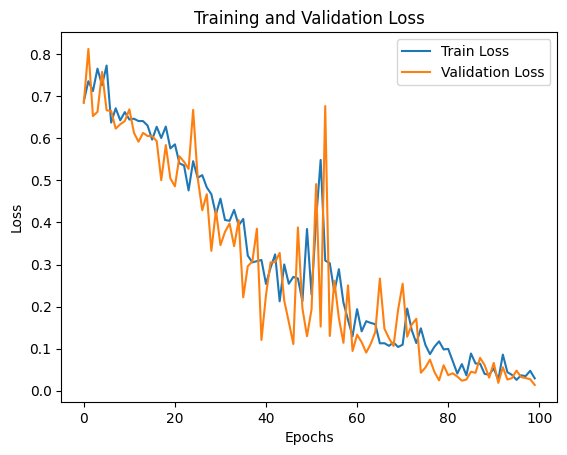

In [15]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Extract training and validation accuracy
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print final accuracy
    print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
    print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")

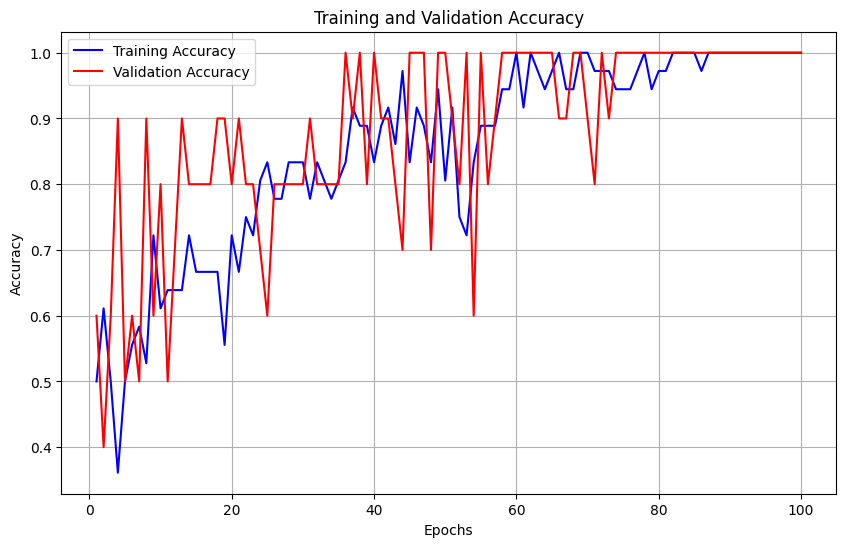

Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000


In [17]:
plot_training_history(history)

In [18]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return conf_matrix

In [19]:
def plot_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['Benign','Malware'])
    print("Classification Report:")
    return report


In [20]:
def plot_accuracy(y_true,y_pred):
    return accuracy_score(y_true, y_pred)

## Stage 4: Testing

In [21]:
## Load model
## from tensorflow.keras.models import load_model
## model = load_model("word2vec_model.h5")

In [22]:
test_sample=get_and_process_sample('processed/Adware/Adware_0603/data_section.bin')
# Add batch dimension
test_sample = np.expand_dims(test_sample, axis=0)
print(model.predict(test_sample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
[[0.01458381 0.98541623]]


In [23]:
NUMBER_OF_TEST_SAMPLE = 50
DATA_CATEGORY =  ['Adware', 'SMS', 'Banking', 'Benign']
SAMPLE_NUMBER= {
    'Benign':1600,
    'Banking':2505,
    'Adware':1514,
    'SMS':4928
}
BENIGN_SAMPLE = 20
ADWARE_SAMPLE = 10
SMS_SAMPLE = 8
BANKING_SAMPLE = 8

ROOT_DIR = r"D:\prj2\processed"

In [24]:
def testing(model):
    y_pred=[]
    y_true=[]
    sample_count = 0
    while sample_count < NUMBER_OF_TEST_SAMPLE:

        category= DATA_CATEGORY[random.randint(0,3)]

        id=random.randint(BENIGN_SAMPLE+600,SAMPLE_NUMBER[category])
        if(category=='Benign'):
            true_label=0
        else:
            true_label=1

        print('Path:',ROOT_DIR+"/"+category+"/"+f"{category}_{str(id).zfill(4)}/data_section.bin")


        test_sample=get_and_process_sample(ROOT_DIR+"/"+category+"/"+f"{category}_{str(id).zfill(4)}/data_section.bin")
        test_sample = np.expand_dims(test_sample, axis=0)
        prediction = model.predict(test_sample)

        print('Prediction:',prediction)

        predicted_classes = np.argmax(prediction, axis=1)  # Get class indices (0 or 1)
        y_true.append(true_label)  # Add true labels
        y_pred.extend(predicted_classes)  # Add predictions
        sample_count+=1

    return (y_true, y_pred)

In [25]:
y_true,y_pred=testing(model)
print('Y_TRUE:')
print(y_true)
print('Y_PRED:')
print(y_pred)
gc.collect()

Path: D:\prj2\processed/Banking/Banking_2265/data_section.bin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Prediction: [[0.2453773 0.7546227]]
Path: D:\prj2\processed/Banking/Banking_1219/data_section.bin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Prediction: [[0.61442024 0.3855798 ]]
Path: D:\prj2\processed/Adware/Adware_0945/data_section.bin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Prediction: [[0.14186643 0.8581336 ]]
Path: D:\prj2\processed/SMS/SMS_2284/data_section.bin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Prediction: [[0.38409692 0.6159031 ]]
Path: D:\prj2\processed/Benign/Benign_1026/data_section.bin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Prediction: [[0.10398555 0.89601445]]
Path: D:\prj2\processed/Banking/Banking_1084/data_section.bin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Prediction: [[0.04532494 0.954675  ]]
Path: D:\prj2\processed/Adware/Adware_0746/data_section.bin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Prediction: [[0.6205343 0.3794657]]
Path: D:\prj2\processed/SMS/SMS_3893/data_sec

5436

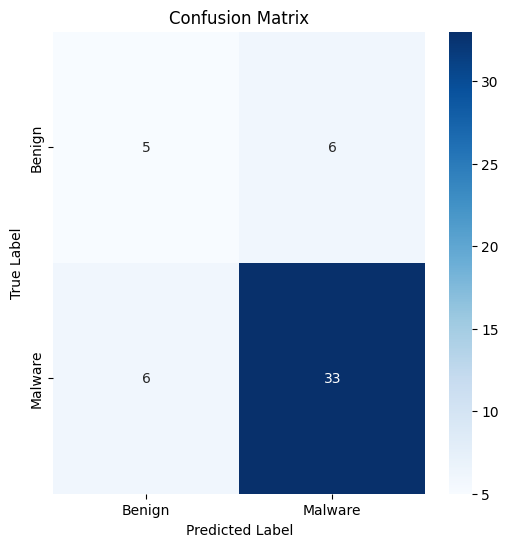

array([[ 5,  6],
       [ 6, 33]], dtype=int64)

In [26]:
plot_confusion_matrix(y_true,y_pred)

In [27]:
report = plot_classification_report(y_true,y_pred)
print(report)



report = plot_accuracy(y_true,y_pred)
print(report)

Classification Report:
              precision    recall  f1-score   support

      Benign       0.45      0.45      0.45        11
     Malware       0.85      0.85      0.85        39

    accuracy                           0.76        50
   macro avg       0.65      0.65      0.65        50
weighted avg       0.76      0.76      0.76        50

0.76


## Test with different epoch

In [28]:
# def testing(model):
#     y_pred=[]
#     y_true=[]
#     sample_count = 0
#     while sample_count < NUMBER_OF_TEST_SAMPLE:

#         category= DATA_CATEGORY[random.randint(0,3)]

#         id=random.randint(BENIGN_SAMPLE+600,SAMPLE_NUMBER[category])
#         if(category=='Benign'):
#             true_label=0
#         else:
#             true_label=1

#         print('Path:',ROOT_DIR+"/"+category+"/"+f"{category}_{str(id).zfill(4)}/data_section.bin")


#         test_sample=get_and_process_sample(ROOT_DIR+"/"+category+"/"+f"{category}_{str(id).zfill(4)}/data_section.bin")
#         test_sample = np.expand_dims(test_sample, axis=0)
#         prediction = model.predict(test_sample)

#         print('Prediction:',prediction)

#         predicted_classes = np.argmax(prediction, axis=1)  # Get class indices (0 or 1)
#         y_true.append(true_label)  # Add true labels
#         y_pred.extend(predicted_classes)  # Add predictions
#         sample_count+=1

#     return (y_true, y_pred)

def testing_2(model):
    y_pred = []
    y_true = []
    sample_count = 0

    while sample_count < NUMBER_OF_TEST_SAMPLE:
        category = DATA_CATEGORY[random.randint(0, 3)]
        id = random.randint(BENIGN_SAMPLE + 600, SAMPLE_NUMBER[category])

        if category == 'Benign':
            true_label = 0
        else:
            true_label = 1

        file_path = os.path.join(ROOT_DIR, category, f"{category}_{str(id).zfill(4)}", "data_section.bin")
        if not os.path.exists(file_path):
            continue  # Skip if file does not exist

        test_sample = get_and_process_sample(file_path)
        test_sample = np.expand_dims(test_sample, axis=0)
        prediction = model.predict(test_sample)

        predicted_classes = np.argmax(prediction, axis=1)
        y_true.append(true_label)
        y_pred.extend(predicted_classes)
        sample_count += 1

    return (y_true, y_pred)

In [29]:
accuracy_list = []
true_positive_rate=[]
false_positive_rate=[]
epoch_ranges = [i for i in range(5,101,5)]

for epoch_count in epoch_ranges:
    model = build_model()
    model_training(epoch_count)
    y_true,y_pred=testing_2(model)

    # Extract TP and FP
    conf_mat = confusion_matrix(y_true,y_pred)
    TP = conf_mat[1, 1] / NUMBER_OF_TEST_SAMPLE  # True Positives are at position [1, 1]
    FP = conf_mat[0, 1] / NUMBER_OF_TEST_SAMPLE # False Positives are at position [0, 1]

    true_positive_rate.append(TP)
    false_positive_rate.append(FP)

    accuracy_list.append(plot_accuracy(y_true,y_pred))

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.5433 - loss: 0.7318 - val_accuracy: 0.4000 - val_loss: 0.7058
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.5344 - loss: 0.7169 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.5867 - loss: 0.6777 - val_accuracy: 0.6000 - val_loss: 0.6637
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.5411 - loss: 0.7310 - val_accuracy: 0.5000 - val_loss: 0.7218
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.6489 - loss: 0.6491 - val_accuracy: 0.4000 - val_loss: 0.7298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/

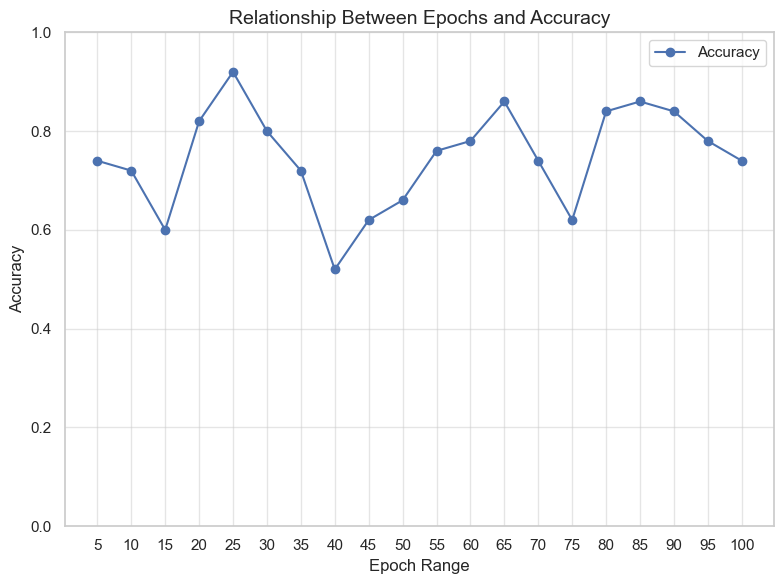

In [30]:
# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(epoch_ranges, accuracy_list, marker='o', linestyle='-', color='b', label="Accuracy")

# Add labels, title, and legend
plt.title("Relationship Between Epochs and Accuracy", fontsize=14)
plt.xlabel("Epoch Range", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(epoch_ranges)
plt.ylim(0, 1)  # Accuracy range is 0 to 1
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

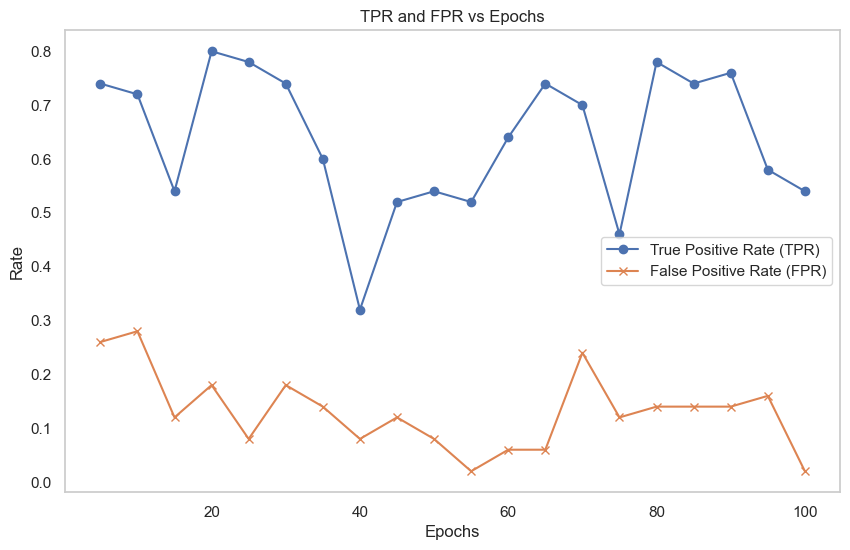

In [31]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epoch_ranges, true_positive_rate, label='True Positive Rate (TPR)', marker='o')
plt.plot(epoch_ranges, false_positive_rate, label='False Positive Rate (FPR)', marker='x')

# Customize the plot
plt.title('TPR and FPR vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

In [33]:
model.save("word2vec_model.h5")